In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import copy

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import savemat
import scipy.signal

import torch
import torchvision
import torchvision.transforms as transforms

import os

# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

import pathlib
from imgaug import augmenters as iaa


%matplotlib notebook
%matplotlib notebook
%matplotlib inline
# %matplotlib qt

In [3]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier')

In [4]:
import sys

sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation

concatenated images shape: (9715, 36, 36)


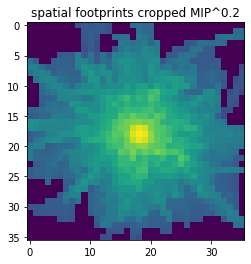

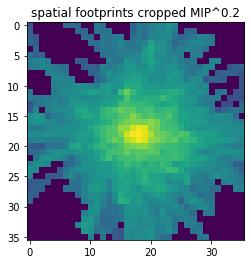

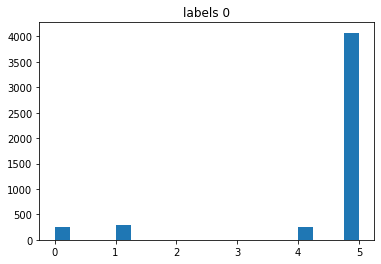

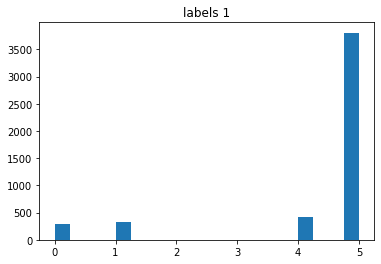

In [5]:
dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images = np.concatenate(sf_all, axis=0) *255
print(f'concatenated images shape: {images.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

In [6]:
duplicates = 1

images_dup = np.tile(images , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)
for ii in np.array([1,4,5]):
#     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
    if ii==5:
        numToGetTo = np.sum(labels_dup==0)/2
    else:
        numToGetTo = np.sum(labels_dup==0)

    idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
    images_dup = images_dup[idxToDelete==0,:,:]
    labels_dup = labels_dup[idxToDelete==0]


print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9715, 36, 36)
(9715,)
532
532
532
532
266
(1863, 36, 36)
(1863,)


In [7]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_dup[:], labels_dup[:], test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((1583, 36, 36), (1583,)), ((280, 36, 36), (280,)))

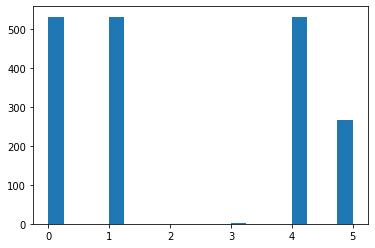

In [8]:
plt.figure()
plt.hist(labels_dup, 20);

In [42]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    
    torchvision.transforms.GaussianBlur(kernel_size=5,
                                        sigma=(0.0001, 1.)),
    
    torchvision.transforms.RandomPerspective(distortion_scale=0.4, 
                                             p=0.5, 
                                             interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                             fill=0),
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.3, 0.3),
                                        scale=(0.7, 1.7), 
                                        shear=(-20, 20, -20, 20), 
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    
    augmentation.AddPoissonNoise(   level_bounds=(0,0.4),
                                    prob=1),

    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.2,
                                    prob=1),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms


dataset_train = util.dataset_simCLR(torch.tensor(X_train), 
                                    y_train, 
                                    n_transforms=2, 
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=1500,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=1,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )

0.001947164535522461


<IPython.core.display.Javascript object>


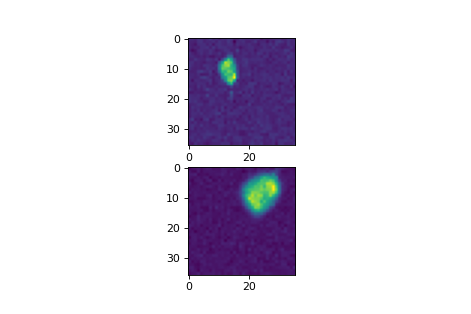

0.029897451400756836


<IPython.core.display.Javascript object>


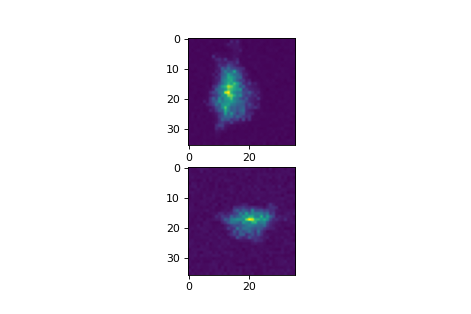

0.028651714324951172


<IPython.core.display.Javascript object>


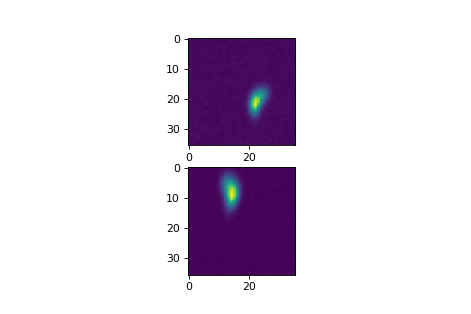

0.02832651138305664


<IPython.core.display.Javascript object>


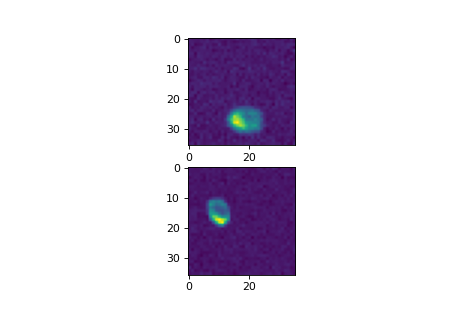

In [43]:
import time

%matplotlib notebook
tic=time.time()
for ii, im in enumerate(dataset_train):
#     for jj in range(im[0])
    print(time.time() - tic)
    tic = time.time()
#     print((im[0][0]).shape)
    fig, axs = plt.subplots(len(im[0]))
    for jj, ax in enumerate(axs):
        ax.imshow(im[0][jj].cpu().squeeze())
    if ii > 2:
        break

In [44]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)
model.train()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.001,
#                                                    gamma=1,
                                                  )
val_obj = training_simCLR.validation_Obj(   X_val,
                                            y_val,
                                            model,
                                            criterion,
                                            DEVICE=DEVICE,
                                            dtype_X=torch.float32,
                                            dtype_y=torch.int64)

model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses_train, losses_val, val_accs = [], [np.nan], []

In [64]:
n_epochs=3000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
                                validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=10,
                               )

epoch: 0
Iter: 0/1, loss_train: 6.8125, loss_val: nan, lr: 0.00074113
epoch: 1
Iter: 0/1, loss_train: 6.7758, loss_val: nan, lr: 0.00074076
epoch: 2
Iter: 0/1, loss_train: 6.7466, loss_val: nan, lr: 0.00074039
epoch: 3
Iter: 0/1, loss_train: 6.7638, loss_val: nan, lr: 0.00074002
epoch: 4
Iter: 0/1, loss_train: 6.7741, loss_val: nan, lr: 0.00073965
epoch: 5
Iter: 0/1, loss_train: 6.7516, loss_val: nan, lr: 0.00073928
epoch: 6
Iter: 0/1, loss_train: 6.7714, loss_val: nan, lr: 0.00073891
epoch: 7
Iter: 0/1, loss_train: 6.7784, loss_val: nan, lr: 0.00073854
epoch: 8
Iter: 0/1, loss_train: 6.7512, loss_val: nan, lr: 0.00073817
epoch: 9
Iter: 0/1, loss_train: 6.7761, loss_val: nan, lr: 0.0007378
epoch: 10
Iter: 0/1, loss_train: 6.7821, loss_val: nan, lr: 0.00073744
epoch: 11
Iter: 0/1, loss_train: 6.7767, loss_val: nan, lr: 0.00073707
epoch: 12
Iter: 0/1, loss_train: 6.7565, loss_val: nan, lr: 0.0007367
epoch: 13
Iter: 0/1, loss_train: 6.7748, loss_val: nan, lr: 0.00073633
epoch: 14
Iter: 0/

Iter: 0/1, loss_train: 6.7487, loss_val: nan, lr: 0.00069936
epoch: 117
Iter: 0/1, loss_train: 6.742, loss_val: nan, lr: 0.00069901
epoch: 118
Iter: 0/1, loss_train: 6.7291, loss_val: nan, lr: 0.00069866
epoch: 119
Iter: 0/1, loss_train: 6.7404, loss_val: nan, lr: 0.00069831
epoch: 120
Iter: 0/1, loss_train: 6.7639, loss_val: nan, lr: 0.00069796
epoch: 121
Iter: 0/1, loss_train: 6.7454, loss_val: nan, lr: 0.00069761
epoch: 122
Iter: 0/1, loss_train: 6.7864, loss_val: nan, lr: 0.00069726
epoch: 123
Iter: 0/1, loss_train: 6.7475, loss_val: nan, lr: 0.00069692
epoch: 124
Iter: 0/1, loss_train: 6.7531, loss_val: nan, lr: 0.00069657
epoch: 125
Iter: 0/1, loss_train: 6.7449, loss_val: nan, lr: 0.00069622
epoch: 126
Iter: 0/1, loss_train: 6.7598, loss_val: nan, lr: 0.00069587
epoch: 127
Iter: 0/1, loss_train: 6.8124, loss_val: nan, lr: 0.00069552
epoch: 128
Iter: 0/1, loss_train: 6.7619, loss_val: nan, lr: 0.00069518
epoch: 129
Iter: 0/1, loss_train: 6.746, loss_val: nan, lr: 0.00069483
epoch

Iter: 0/1, loss_train: 6.7261, loss_val: nan, lr: 0.00066027
epoch: 232
Iter: 0/1, loss_train: 6.7363, loss_val: nan, lr: 0.00065994
epoch: 233
Iter: 0/1, loss_train: 6.7257, loss_val: nan, lr: 0.00065961
epoch: 234
Iter: 0/1, loss_train: 6.739, loss_val: nan, lr: 0.00065928
epoch: 235
Iter: 0/1, loss_train: 6.7271, loss_val: nan, lr: 0.00065895
epoch: 236
Iter: 0/1, loss_train: 6.7277, loss_val: nan, lr: 0.00065862
epoch: 237
Iter: 0/1, loss_train: 6.756, loss_val: nan, lr: 0.00065829
epoch: 238
Iter: 0/1, loss_train: 6.7769, loss_val: nan, lr: 0.00065796
epoch: 239
Iter: 0/1, loss_train: 6.7457, loss_val: nan, lr: 0.00065764
epoch: 240
Iter: 0/1, loss_train: 6.7272, loss_val: nan, lr: 0.00065731
epoch: 241
Iter: 0/1, loss_train: 6.7013, loss_val: nan, lr: 0.00065698
epoch: 242
Iter: 0/1, loss_train: 6.7341, loss_val: nan, lr: 0.00065665
epoch: 243
Iter: 0/1, loss_train: 6.7314, loss_val: nan, lr: 0.00065632
epoch: 244
Iter: 0/1, loss_train: 6.7138, loss_val: nan, lr: 0.00065599
epoch

Iter: 0/1, loss_train: 6.7253, loss_val: nan, lr: 0.00062337
epoch: 347
Iter: 0/1, loss_train: 6.6993, loss_val: nan, lr: 0.00062306
epoch: 348
Iter: 0/1, loss_train: 6.6868, loss_val: nan, lr: 0.00062274
epoch: 349
Iter: 0/1, loss_train: 6.7287, loss_val: nan, lr: 0.00062243
epoch: 350
Iter: 0/1, loss_train: 6.7249, loss_val: nan, lr: 0.00062212
epoch: 351
Iter: 0/1, loss_train: 6.7323, loss_val: nan, lr: 0.00062181
epoch: 352
Iter: 0/1, loss_train: 6.7164, loss_val: nan, lr: 0.0006215
epoch: 353
Iter: 0/1, loss_train: 6.727, loss_val: nan, lr: 0.00062119
epoch: 354
Iter: 0/1, loss_train: 6.7157, loss_val: nan, lr: 0.00062088
epoch: 355
Iter: 0/1, loss_train: 6.7088, loss_val: nan, lr: 0.00062057
epoch: 356
Iter: 0/1, loss_train: 6.7312, loss_val: nan, lr: 0.00062026
epoch: 357
Iter: 0/1, loss_train: 6.7014, loss_val: nan, lr: 0.00061995
epoch: 358
Iter: 0/1, loss_train: 6.7039, loss_val: nan, lr: 0.00061964
epoch: 359
Iter: 0/1, loss_train: 6.7035, loss_val: nan, lr: 0.00061933
epoch

Iter: 0/1, loss_train: 6.7104, loss_val: nan, lr: 0.00058853
epoch: 462
Iter: 0/1, loss_train: 6.7586, loss_val: nan, lr: 0.00058823
epoch: 463
Iter: 0/1, loss_train: 6.7162, loss_val: nan, lr: 0.00058794
epoch: 464
Iter: 0/1, loss_train: 6.6914, loss_val: nan, lr: 0.00058764
epoch: 465
Iter: 0/1, loss_train: 6.7102, loss_val: nan, lr: 0.00058735
epoch: 466
Iter: 0/1, loss_train: 6.7134, loss_val: nan, lr: 0.00058706
epoch: 467
Iter: 0/1, loss_train: 6.7113, loss_val: nan, lr: 0.00058676
epoch: 468
Iter: 0/1, loss_train: 6.6734, loss_val: nan, lr: 0.00058647
epoch: 469
Iter: 0/1, loss_train: 6.6939, loss_val: nan, lr: 0.00058618
epoch: 470
Iter: 0/1, loss_train: 6.735, loss_val: nan, lr: 0.00058588
epoch: 471
Iter: 0/1, loss_train: 6.7296, loss_val: nan, lr: 0.00058559
epoch: 472
Iter: 0/1, loss_train: 6.6981, loss_val: nan, lr: 0.0005853
epoch: 473
Iter: 0/1, loss_train: 6.7077, loss_val: nan, lr: 0.00058501
epoch: 474
Iter: 0/1, loss_train: 6.7029, loss_val: nan, lr: 0.00058471
epoch

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


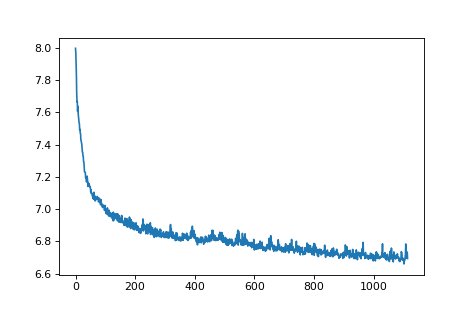

In [65]:
plt.figure()
plt.plot(losses_train)

In [66]:
features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [67]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [68]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=30.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
                     square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

<IPython.core.display.Javascript object>


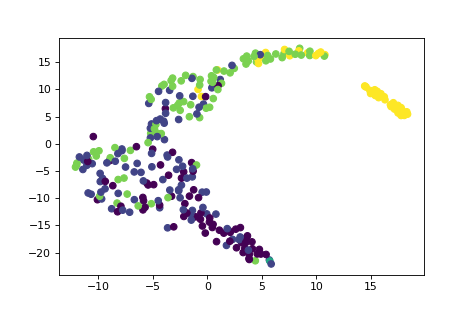

In [69]:
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)

In [70]:
list(model.state_dict().keys())

['cnn_layers.0.weight',
 'cnn_layers.0.bias',
 'cnn_layers.2.weight',
 'cnn_layers.2.bias',
 'cnn_layers.5.weight',
 'cnn_layers.5.bias',
 'cnn_layers.8.weight',
 'cnn_layers.8.bias',
 'linear_layers.0.weight',
 'linear_layers.0.bias',
 'linear_layers.2.weight',
 'linear_layers.2.bias']

<IPython.core.display.Javascript object>


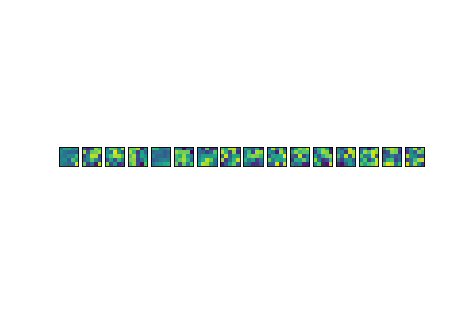

<IPython.core.display.Javascript object>


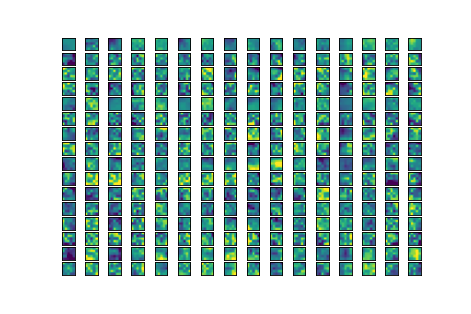

<IPython.core.display.Javascript object>


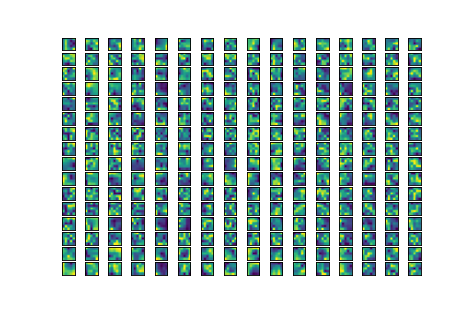

In [71]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
# layer_4 = model.state_dict()['cnn_layers.11.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
# for ii in range(1):
#     for jj in range(6):
#         plt.subplot2grid((1,6),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        #         im = plt.gca().get_images()
#         im.set_clim(0,1)
plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
# for ii in range(12):
#     for jj in range(12):
#         plt.subplot2grid((12,12),(ii,jj))
        #         plt.imshow(layer_2[ii*jj + jj,0,:,:])
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
# #         fig = plt.imshow(layer_3[jj*ii + jj,0,:,:], clim=(-.01,.01))
# #         fig.axes.get_xaxis().set_visible(False)
# #         fig.axes.get_yaxis().set_visible(False)
# plt.figure()
# for ii in range(layer_3.shape[1]):
#     for jj in range(layer_3.shape[0]):
#         plt.subplot2grid((layer_3.shape[1],layer_3.shape[0]),(ii,jj))
#         fig = plt.imshow(layer_3[jj, ii,:,:], clim=(-.4,.4))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
        
        
        
        
# plt.figure()
# for ii in range(layer_4.shape[1]):
#     for jj in range(layer_4.shape[0]):
#         plt.subplot2grid((layer_4.shape[1],layer_4.shape[0]),(ii,jj))
#         fig = plt.imshow(layer_4[jj, ii,:,:], clim=(-.2,.2))
#         fig.axes.get_xaxis().set_visible(False)
#         fig.axes.get_yaxis().set_visible(False)
# # model.state_dict()['cnn_layers.1.weight'].shape